# Importing the dependencies

In [1]:
import os
import json
import ast

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from wordcloud import WordCloud
from scipy.stats import skew, yeojohnson, boxcox
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, FunctionTransformer, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

# Set Seaborn theme
sns.set_theme(style="whitegrid")

# Display full view of the rows and columns of the dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Data Loading

In [2]:
# Loading the data from saved CSV files
df1 = pd.read_csv('../Dataset/Prediction_ds/men-accessories.csv')
df2 = pd.read_csv('../Dataset/Prediction_ds/men-casual-shirts.csv')
df3 = pd.read_csv('../Dataset/Prediction_ds/men-casual-trousers.csv')
df4 = pd.read_csv('../Dataset/Prediction_ds/men-formal-shirts.csv')
df5 = pd.read_csv('../Dataset/Prediction_ds/men-formal-trousers.csv')
df6 = pd.read_csv('../Dataset/Prediction_ds/men-innerwear-and-sleapwear.csv')
df7 = pd.read_csv('../Dataset/Prediction_ds/men-jackets-coats.csv')
df8 = pd.read_csv('../Dataset/Prediction_ds/men-jeans.csv')
df9 = pd.read_csv('../Dataset/Prediction_ds/men-suits.csv')
df10 = pd.read_csv('../Dataset/Prediction_ds/men-swimwear.csv')
df11 = pd.read_csv('../Dataset/Prediction_ds/men-track-pants.csv')
df12 = pd.read_csv('../Dataset/Prediction_ds/men-tshirts.csv')

# Concatenating all the DataFrames along axis = 0
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12], axis=0)

# Shuffling and Resetting the index
df = df.sample(frac=1).reset_index(drop=True)

### Defining utility functions

In [3]:
def invert_yeojhonson(value, lmbda):
    if value >= 0 and lmbda == 0:
        return math.exp(value) - 1
    elif value >= 0 and lmbda != 0:
        return (value * lmbda + 1) ** (1 / lmbda) - 1
    elif value < 0 and lmbda != 2:
        return 1 - (-(2 - lmbda) * value + 1) ** (1 / (2 - lmbda))
    elif value < 0 and lmbda == 2:
        return 1 - math.exp(-value)

# Understanding the data (Overview)

In [4]:
print("Shape of the dataframe : ",df.shape)

Shape of the dataframe :  (61503, 11)


In [5]:
df.sample(3)

,SERIAL NO,NAME,CATEGORY,DESCRIPTION & COLOR,FABRIC,IMAGE,SIZE,PRICE,PRODUCT ID,WEBSITE,PRODUCT URL
4676,851,GAP Men Navy Blue Self Design Round Neck T-shirt,T-Shirts,GAP Men Navy Blue Self Design Round Neck T Shi...,100% Cotton,"https://assets.myntassets.com/h_1440,q_100,w_1...",The model (height 6') is wearing a size M,1499,8515563,Myntra,https://www.myntra.com/tshirts/gap/gap-men-nav...
7815,245,Peter England Men Cream-Coloured Nuvo Regular ...,formal-shirts,Peter England Men Cream Coloured Nuvo Regular ...,"60% cotton, 40% polyester","https://assets.myntassets.com/h_1440,q_100,w_1...",Nuvo - Regular Fit,649,7375309,Myntra,https://www.myntra.com/shirts/peter-england/pe...
26107,6854,Kook N Keech Marvel Men Blue Mid-Rise Mildly D...,Jeans,Kook N Keech Marvel Men Blue Mid Rise Mildly D...,Cotton,"https://assets.myntassets.com/h_1440,q_100,w_1...",Regular Fit,1399,4929033,Myntra,https://www.myntra.com/jeans/kook-n-keech-marv...


In [6]:
# Defining all the 
exclude_attributes = ['SERIAL NO', 'SERIAL NO','PRODUCT URL','IMAGE','PRODUCT ID','WEBSITE']

# Dropping unnecessary columns
df.drop(exclude_attributes,axis=1,inplace=True)

In [7]:
# Information about the attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61503 entries, 0 to 61502
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   NAME                 61502 non-null  object
 1   CATEGORY             61503 non-null  object
 2   DESCRIPTION & COLOR  61503 non-null  object
 3   FABRIC               56664 non-null  object
 4   SIZE                 57661 non-null  object
 5   PRICE                61503 non-null  object
dtypes: object(6)
memory usage: 2.8+ MB


In [8]:
# Let's check percentage of missing values
df.isnull().mean()*100

NAME                   0.001626
CATEGORY               0.000000
DESCRIPTION & COLOR    0.000000
FABRIC                 7.867909
SIZE                   6.246850
PRICE                  0.000000
dtype: float64

# Exploratory data analysis

In [9]:
df.head(5)

,NAME,CATEGORY,DESCRIPTION & COLOR,FABRIC,SIZE,PRICE
0,Navy Blue Printed Slim Fit Round Neck T-Shirt,T-Shirts,"Navy Blue Printed Slim Fit Round Neck T Shirt,...",NaN,NaN,594
1,Blackberrys Men Grey Regular Fit Solid Trousers,Men-Casual-Trousers,Blackberrys Men Grey Regular Fit Solid Trouser...,"98% cotton, 2% elastane",Regular Fit,1197
2,Estrolo Men Blue Slim Fit Mid-Rise Low Distres...,Jeans,Estrolo Men Blue Slim Fit Mid Rise Low Distres...,99% Cotton and 1% Elastane,Slim fit,1199
3,Kook N Keech Disney Men Charcoal Printed Round...,T-Shirts,Kook N Keech Disney Men Charcoal Printed Round...,Cotton,The model (height 6') is wearing a size M,439
4,V Dot Men Blue Slim Fit Self Design Formal Shirt,formal-shirts,V Dot Men Blue Slim Fit Self Design Formal Shi...,Cotton,Slim fit,1322


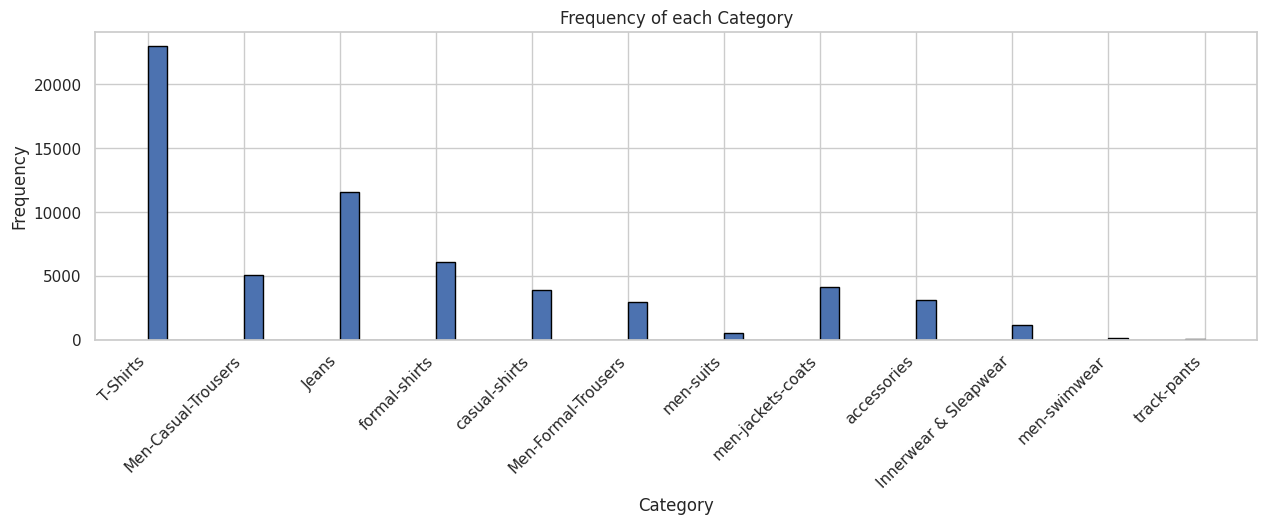

In [10]:
# Assuming df has 'CATEGORY' column
plt.figure(figsize=(15, 4))

# Histogram for CATEGORY
plt.hist(df['CATEGORY'], bins='auto', edgecolor='black')
plt.title('Frequency of each Category')
plt.xlabel('Category')
plt.ylabel('Frequency')

# Rotate x-axis ticks
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

In [11]:
men_fashion_colors = [
    "black", "white", "gray", "navy", "khaki", "brown", "charcoal", "beige", 
    "burgundy", "maroon", "blue", "green", "tan", "camel", "dark blue", "light blue", 
    "dark green", "light green", "dark brown", "light brown", "dark gray", "light gray", 
    "charcoal gray", "aubergine", "midnight blue", "indigo", "rust", "mustard", "wine", 
    "copper", "taupe", "stone", "cream", "ivory", "chocolate", "teal", "mocha", "slate", 
    "forest green", "sky blue", "denim", "steel blue", "cobalt", "teal", "plum", "mahogany", 
    "olive green", "cherry red", "sage green", "pine green", "steel gray"
]

men_fashion_colors_set = set(men_fashion_colors)
colors_found = []

# Iterating over all the rows
for i in range(len(df)):
    item = df.iloc[i]['DESCRIPTION & COLOR']
    current_row_clrs = []
    for color in men_fashion_colors_set:
        if color in item.lower():
            current_row_clrs.append(color)
    colors_found.append(current_row_clrs)

In [12]:
# Adding new feature in the dataframe
df['Color'] = colors_found
df.drop(['DESCRIPTION & COLOR'],axis=1,inplace=True)

In [13]:
for i in range(len(colors_found)):
    list = colors_found[i]
    if len(list) != 0:
        df.loc[i,'Color'] = list[0]
    else:
        df.loc[i,'Color'] = 'black'

In [14]:
# Lowercasing the values and also doing the missing values imputation using the mode imputation
df['FABRIC'] = df['FABRIC'].str.lower()
df['FABRIC'] = df['FABRIC'].fillna(df['FABRIC'].mode()[0])

In [15]:
# Replacing the niche values with general values to make things consistent
df['FABRIC'] = df['FABRIC'].str.replace('100% cotton', 'cotton')
df['FABRIC'] = df['FABRIC'].str.replace('100% polyester', 'polyester')

In [16]:
fabric_types = set(['cotton', 'leather', 'polyester', 'elastane', 'pu', 'spandex', 'nylon',
                'wool', 'linen', 'silk', 'rayon', 'viscose', 'denim', 'corduroy', 'twill',
                'flannel', 'velvet', 'canvas', 'satin', 'chino', 'jersey', 'tweed', 'cashmere',
                'tencel', 'modal', 'velour', 'burlap', 'gabardine', 'herringbone', 'cambric',
                'seersucker', 'poplin', 'tulle', 'poplin', 'organza', 'batiste', 'broadcloth'])

fabrics_list = []
for i in range(len(df)):
    item = df.iloc[i]['FABRIC']
    row_fabrics = []
    for types in fabric_types:
        if types in item.split():
            row_fabrics.append(types)

    # Sort of doing the mode imputation
    if len(row_fabrics) > 0:
        fabrics_list.append(row_fabrics)
    else:
        fabrics_list.append('cotton')

In [17]:
df['Fabrics'] = fabrics_list
df.drop(['FABRIC'],axis=1,inplace=True)

# Concatenate all values in the lists into a single value
df['Fabrics'] = df['Fabrics'].apply(lambda x: '_'.join(map(str, x)))

In [18]:
# Getting all the value counts
Fabrics_concatenated_counts = df['Fabrics'].value_counts()

df = df[df['Fabrics'].map(Fabrics_concatenated_counts) >= 30]
df['Fabrics'] = df['Fabrics'].replace('c_o_t_t_o_n','cotton')

In SIZE feature, especially for the CATEGORY = 'accesories' there is basically no consistency so we will simply remove all the accesories from the dataframe and we will only consider other CATEGORY types only as our recommendation engine will also be focussed on the items which are not accesories.

In [19]:
# Removing tupes with CATEGORY = accesories
df = df[~(df['CATEGORY'] == 'accessories')]
df.reset_index(drop=True,inplace=True)

In [20]:
# Imputing the missing values with mode value
df['SIZE'] = df['SIZE'].fillna(df['SIZE'].mode()[0])
df['SIZE'] = df['SIZE'].str.lower()

# Going over the values of CATEGORY feature
for i in range(len(df)):
    item = df.loc[i, 'SIZE']
    
    # Check if 'model' is in the item
    if 'model' in item.split():
        df.loc[i, 'SIZE'] = item.split()[-1]

    if 'slim' in item.split() or '-slim' in item.split():
        df.loc[i, 'SIZE'] = 'slim fit'
        
    if 'skinny' in item.split():
        df.loc[i, 'SIZE'] = 'skinny fit'

    if 'regular' in item.split():
        df.loc[i, 'SIZE'] = 'regular fit'

    if 'tapered' in item.split():
        df.loc[i, 'SIZE'] = 'tapered fit'

    if 'tailored' in item.split():
        df.loc[i, 'SIZE'] = 'tailored fit'

    if 'sharp' in item.split():
        df.loc[i, 'SIZE'] = 'sharp fit'

In [21]:
size_counts = df['SIZE'].value_counts()

# Dropping rows with 'CATEGORY' frequency count < 30, you can do:
df = df[df['SIZE'].map(size_counts) >= 30]

In [22]:
df['SIZE'] = df['SIZE'].replace('xl','tshirt_xl')
df['SIZE'] = df['SIZE'].replace('l','tshirt_l')
df['SIZE'] = df['SIZE'].replace('xxl','tshirt_xxl')
df['SIZE'] = df['SIZE'].replace('s','tshirt_s')
df['SIZE'] = df['SIZE'].replace('m','tshirt_m')
df['SIZE'] = df['SIZE'].replace('3xl','tshirt_3xl')
df['SIZE'] = df['SIZE'].replace('32','jean_trouser_32')
df['SIZE'] = df['SIZE'].replace('40','jean_trouser_40')
df['SIZE'] = df['SIZE'].replace('contemporary fit ','contemporary fit')

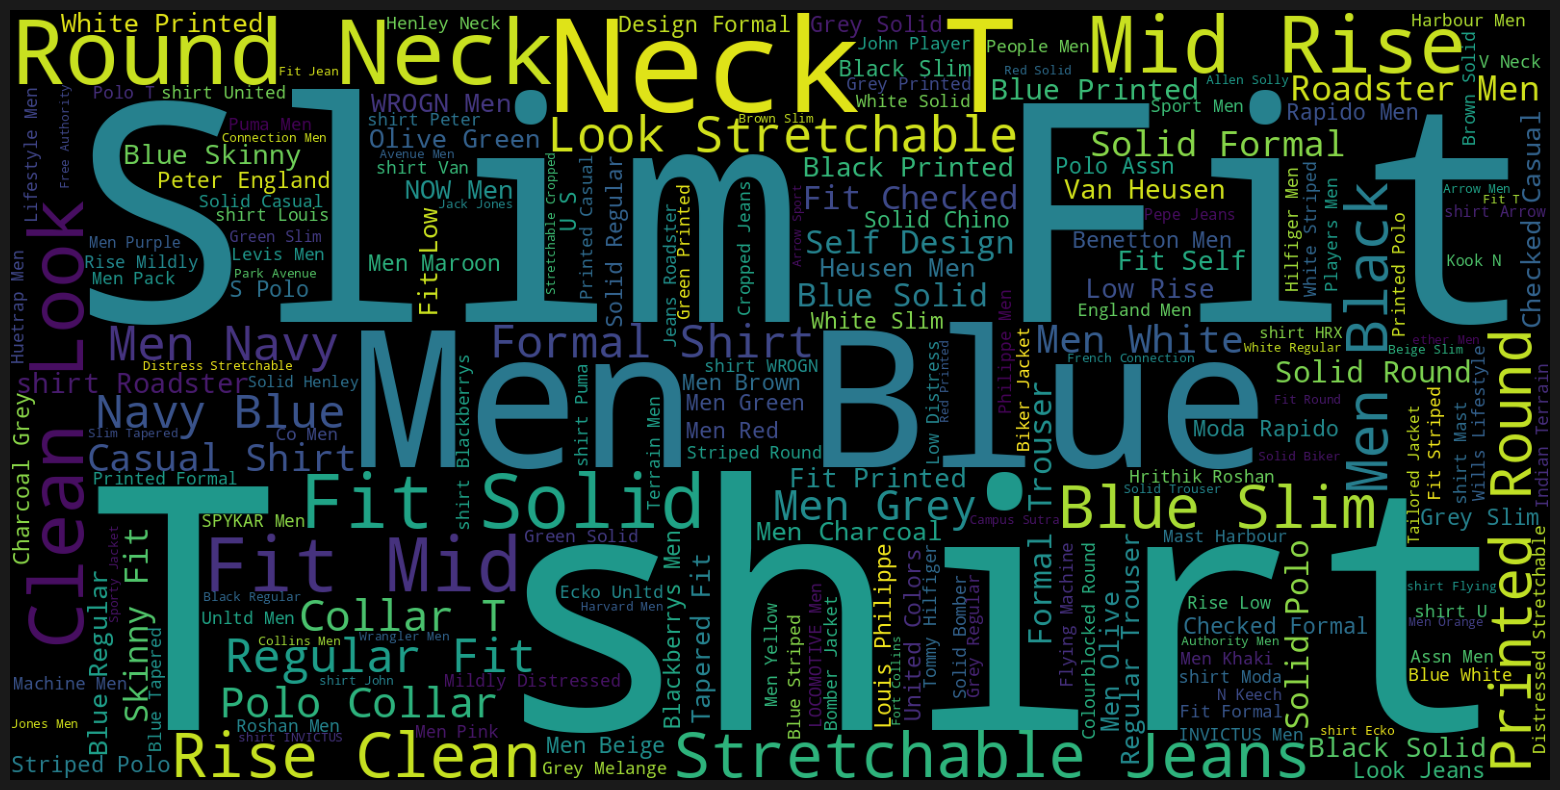

In [23]:
# Extracting the course titles and joining sentences into a single string
df['NAME'] = df['NAME'].fillna(df['NAME'].mode()[0])
content_text = df["NAME"] 
content_text_string = " ".join(content_text.tolist())  

# Set other parameters
wordcloud = WordCloud(width=1600, height=800).generate(content_text_string)

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('../Notebook/wordcloud.png', facecolor='k')

Now since we have discovered the mostly coming keywords in the complete corpus related to NAME so we will now simply remove the NAME feature from the dataframe.

In [24]:
df.drop(['NAME'],axis=1,inplace=True)

In [26]:
# Price feature have some sentences so we need to remove them and replace them with the nan values
df['PRICE'] = df['PRICE'].apply(lambda x: int(x) if isinstance(x, str) and len(x.split()) == 1 else np.nan)
df.to_csv('../Dataset/Prediction_ds/Cleanend_dataV1.csv')

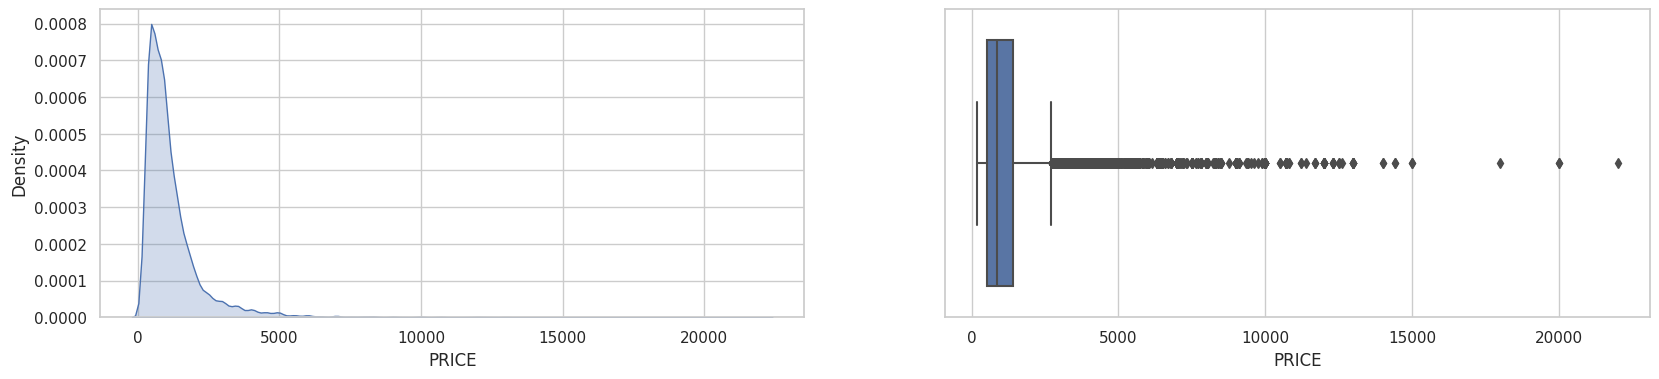

In [35]:
fig,ax = plt.subplots(1,2,figsize=(20,4))

sns.kdeplot(df['PRICE'],fill=True,ax = ax[0])
sns.boxplot(x = df['PRICE'],ax = ax[1])
plt.show()

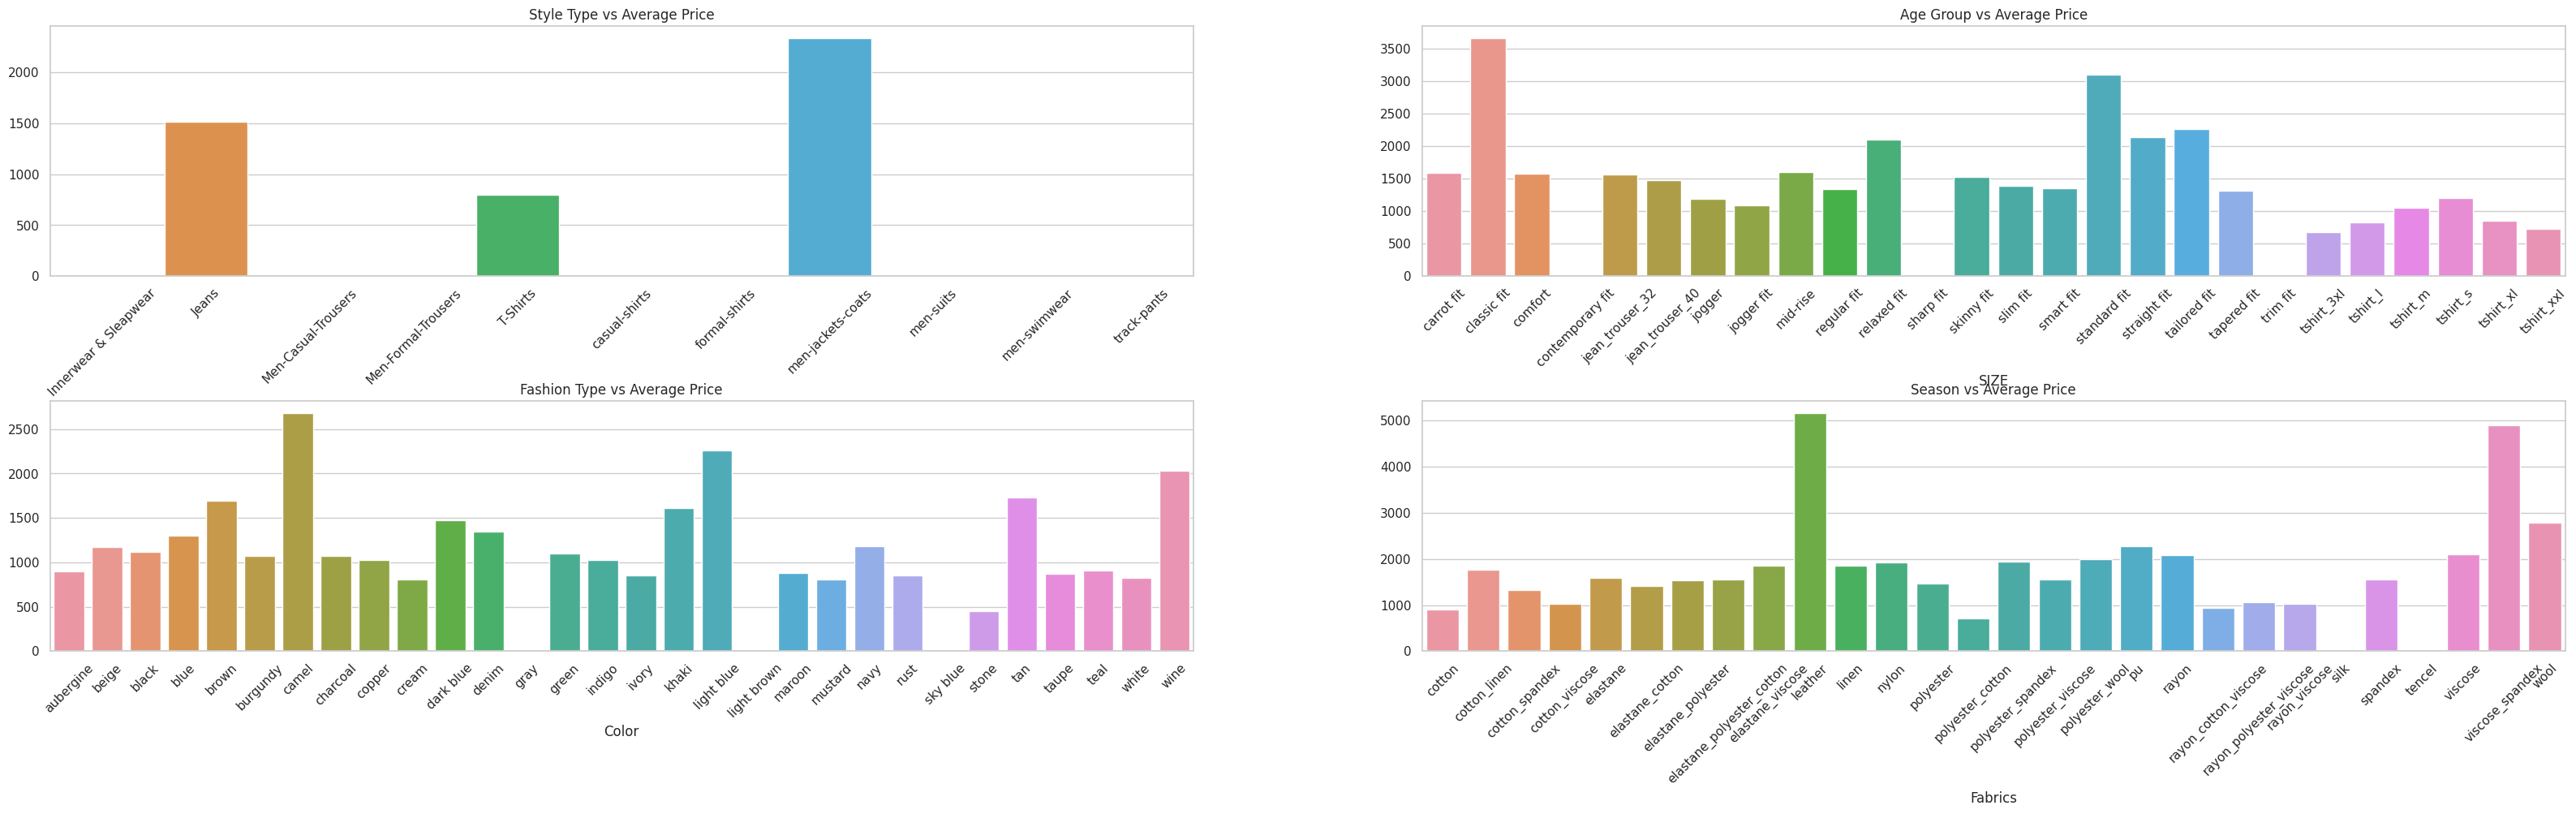

In [40]:
# Grouping data
category_dist = df.groupby('CATEGORY')['PRICE'].mean()
size_dist = df.groupby('SIZE')['PRICE'].mean()
color_dist = df.groupby('Color')['PRICE'].mean()
fabrics_dist = df.groupby('Fabrics')['PRICE'].mean()

# Creating subplots
fig, ax = plt.subplots(2, 2, figsize=(40, 10))

# Plotting each distribution
sns.barplot(x=category_dist.index, y=category_dist.values, ax=ax[0][0])
ax[0][0].set_title("Style Type vs Average Price")

sns.barplot(x=size_dist.index, y=size_dist.values, ax=ax[0][1])
ax[0][1].set_title("Age Group vs Average Price")

sns.barplot(x=color_dist.index, y=color_dist.values, ax=ax[1][0])
ax[1][0].set_title("Fashion Type vs Average Price")

sns.barplot(x=fabrics_dist.index, y=fabrics_dist.values, ax=ax[1][1])
ax[1][1].set_title("Season vs Average Price")

# Setting x-axis labels rotation
for i in range(2):
    for j in range(2):
        ax[i][j].tick_params(axis='x', labelrotation=45)

# Adjusting subplot layout
plt.subplots_adjust(hspace=0.5)

# Displaying the plot
plt.show()

# Feature engineering

In [77]:
columns = ['isEMIEnabled','isReturnable','isExchangeable','discount_available']
for cols in columns:
    df[cols] = df[cols].astype(int)

df['vat'] = df['vat'].astype(object)

In [115]:
temp = df.copy()
temp.head(5)

,price,styleType,brandName,ageGroup,baseColour,fashionType,season,usage,vat,isEMIEnabled,isReturnable,isExchangeable,discount_available
1,2199.0,P,FILA,Adults-Men,Black,Core,Summer,Casual,14.5,1,1,1,0
2,2499.0,P,FILA,Adults-Men,Black,Fashion,Fall,Sports,14.5,1,1,1,0
3,1695.0,RTV,Fossil,Adults-Men,Black,Fashion,Fall,Casual,14.5,1,1,1,1
4,1525.0,P,Lucera,Adults-Women,Silver,Fashion,Summer,Casual,5.5,0,1,1,1
5,899.0,P,Puma,Adults-Women,Black,Fashion,Fall,Casual,5.5,0,1,1,0


In [117]:
# Instantiate target encoder classes
TE_styletype = ce.TargetEncoder()
TE_brandName = ce.TargetEncoder()
TE_baseColour = ce.TargetEncoder()
TE_agegrp = ce.TargetEncoder()
TE_fashionType = ce.TargetEncoder()
TE_season = ce.TargetEncoder()
TE_usage = ce.TargetEncoder()
TE_vat = ce.TargetEncoder()

# Fit the TargetEncoder to the training data
TE_styletype.fit(temp['styleType'], temp['price'])
TE_brandName.fit(temp['brandName'], temp['price'])
TE_baseColour.fit(temp['baseColour'], temp['price'])
TE_agegrp.fit(temp['ageGroup'], temp['price'])
TE_fashionType.fit(temp['fashionType'], temp['price'])
TE_season.fit(temp['season'], temp['price'])
TE_usage.fit(temp['usage'], temp['price'])
TE_vat.fit(temp['vat'], temp['price'])

# Transform the categorical variables using the fitted encoders
temp['styleType'] = TE_styletype.transform(temp['styleType'])
temp['brandName'] = TE_brandName.transform(temp['brandName'])
temp['baseColour'] = TE_baseColour.transform(temp['baseColour'])
temp['ageGroup'] = TE_agegrp.transform(temp['ageGroup'])
temp['fashionType'] = TE_fashionType.transform(temp['fashionType'])
temp['season'] = TE_season.transform(temp['season'])
temp['usage'] = TE_usage.transform(temp['usage'])
temp['vat'] = TE_vat.transform(temp['vat'])

In [118]:
temp.head(4)

,price,styleType,brandName,ageGroup,baseColour,fashionType,season,usage,vat,isEMIEnabled,isReturnable,isExchangeable,discount_available
1,2199.0,1772.769898,1685.972340,1948.292689,2065.987268,1208.254534,1458.690320,1602.054368,2271.658652,1,1,1,0
2,2499.0,1772.769898,1685.972340,1948.292689,2065.987268,1739.490931,1723.251048,2679.893565,2271.658652,1,1,1,0
3,1695.0,1254.946673,5473.899676,1948.292689,2065.987268,1739.490931,1723.251048,1602.054368,2271.658652,1,1,1,1
4,1525.0,1772.769898,2967.055375,1506.181706,2952.179775,1739.490931,1458.690320,1602.054368,1116.076180,0,1,1,1


In [98]:
# Instantiating target encoder class
TE_styletype = ce.TargetEncoder()
TE_brandName = ce.TargetEncoder()
TE_baseColour = ce.TargetEncoder()
TE_agegrp = ce.TargetEncoder()

# Fit the TargetEncoder to the training data
TE_styletype.fit(temp['styleType'], temp['price'])
TE_brandName.fit(temp['brandName'], temp['price'])
TE_baseColour.fit(temp['baseColour'], temp['price'])
TE_agegrp.fit(temp['ageGroup'], temp['price'])

# Transform the categorical variables using the fitted encoders
temp['styleType'] = TE_styletype.transform(temp['styleType'])
temp['brandName'] = TE_brandName.transform(temp['brandName'])
temp['baseColour'] = TE_baseColour.transform(temp['baseColour'])
temp['ageGroup'] = TE_agegrp.transform(temp['ageGroup'])

In [119]:
temp.head(5)

,price,styleType,brandName,ageGroup,baseColour,fashionType,season,usage,vat,isEMIEnabled,isReturnable,isExchangeable,discount_available
1,2199.0,1772.769898,1685.972340,1948.292689,2065.987268,1208.254534,1458.690320,1602.054368,2271.658652,1,1,1,0
2,2499.0,1772.769898,1685.972340,1948.292689,2065.987268,1739.490931,1723.251048,2679.893565,2271.658652,1,1,1,0
3,1695.0,1254.946673,5473.899676,1948.292689,2065.987268,1739.490931,1723.251048,1602.054368,2271.658652,1,1,1,1
4,1525.0,1772.769898,2967.055375,1506.181706,2952.179775,1739.490931,1458.690320,1602.054368,1116.076180,0,1,1,1
5,899.0,1772.769898,2141.114327,1506.181706,2065.987268,1739.490931,1723.251048,1602.054368,1116.076180,0,1,1,0


In [100]:
fashiontype_encoded = pd.get_dummies(temp['fashionType'])
# ageGroup_encoded = pd.get_dummies(temp['ageGroup'])
season_encoded = pd.get_dummies(temp['season'])
usage_encoded = pd.get_dummies(temp['usage'])

In [101]:
# Concatenate the encoded columns to the original DataFrame
temp = pd.concat([temp, fashiontype_encoded,season_encoded,usage_encoded], axis=1)
temp.drop(['fashionType','season','usage'],axis=1,inplace=True)

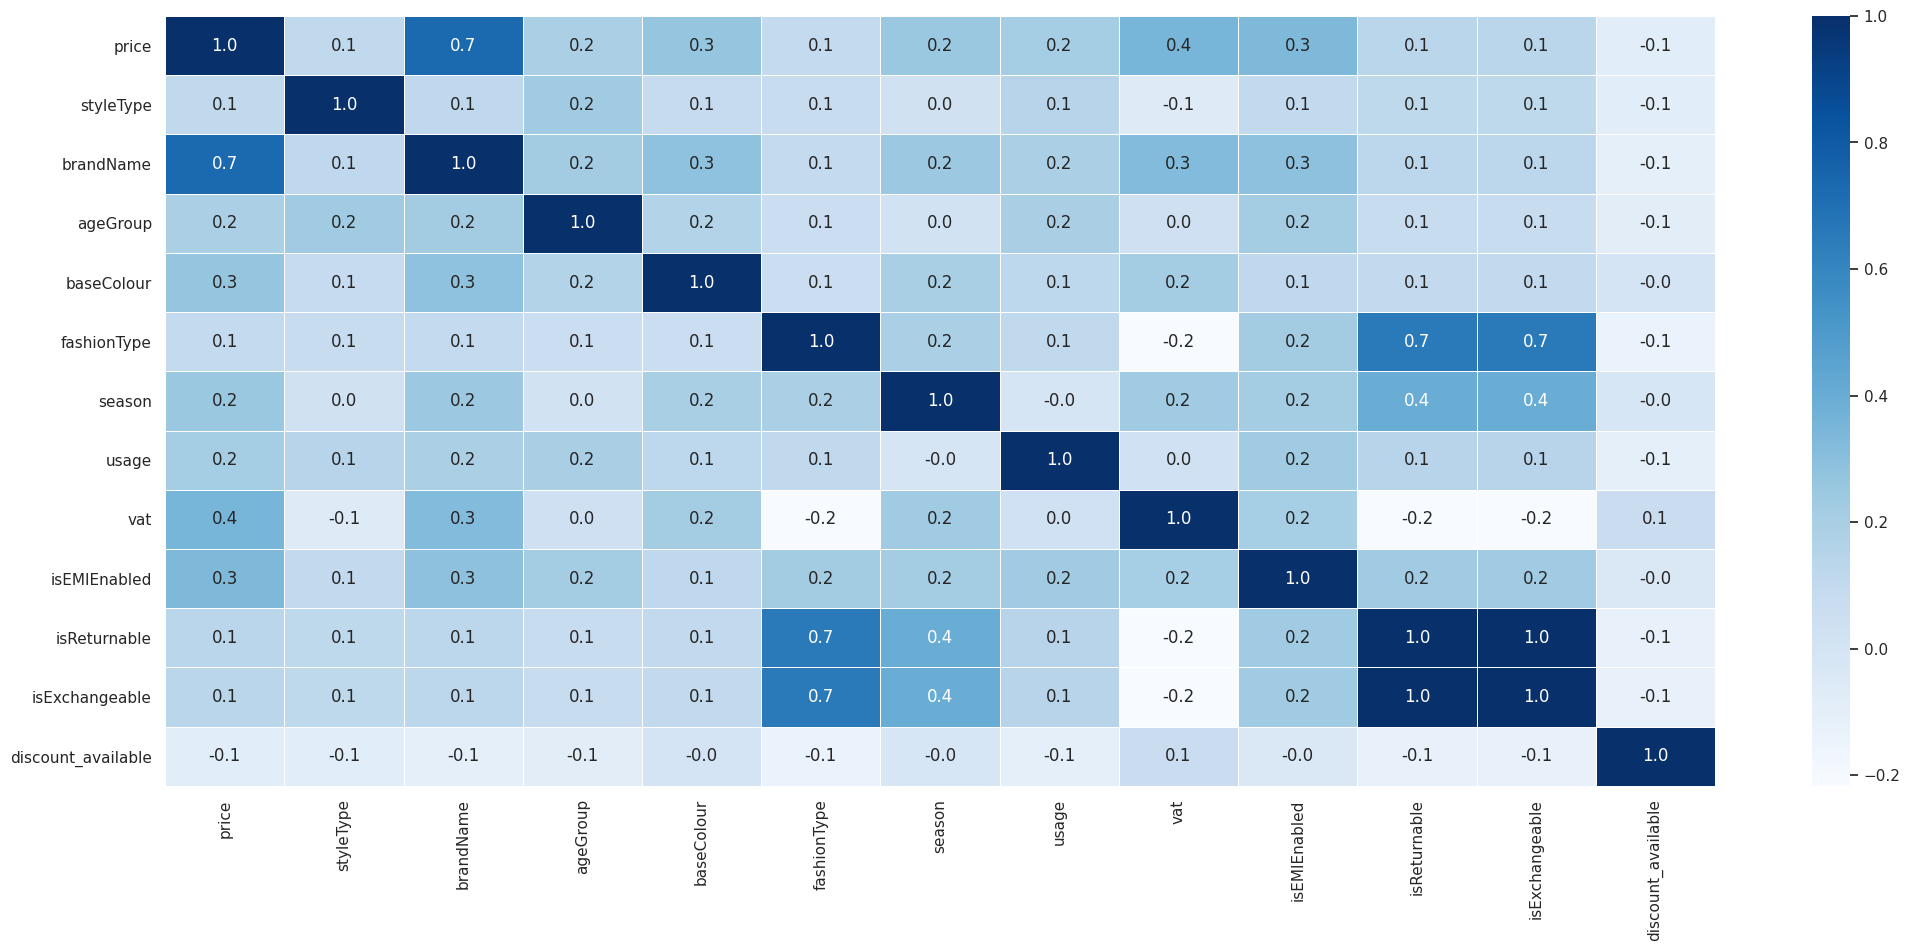

In [120]:
plt.figure(figsize=(25, 10))
sns.heatmap(temp.corr(),annot=True,cmap="Blues", fmt=".1f",linewidth=.5)
plt.show()

In [126]:
temp.head(5)

,price,styleType,brandName,ageGroup,baseColour,fashionType,season,usage,vat,isEMIEnabled,isReturnable,isExchangeable,discount_available
1,2199.0,1772.769898,1685.972340,1948.292689,2065.987268,1208.254534,1458.690320,1602.054368,2271.658652,1,1,1,0
2,2499.0,1772.769898,1685.972340,1948.292689,2065.987268,1739.490931,1723.251048,2679.893565,2271.658652,1,1,1,0
3,1695.0,1254.946673,5473.899676,1948.292689,2065.987268,1739.490931,1723.251048,1602.054368,2271.658652,1,1,1,1
4,1525.0,1772.769898,2967.055375,1506.181706,2952.179775,1739.490931,1458.690320,1602.054368,1116.076180,0,1,1,1
5,899.0,1772.769898,2141.114327,1506.181706,2065.987268,1739.490931,1723.251048,1602.054368,1116.076180,0,1,1,0


In [16]:
fashiontype_encoded = pd.get_dummies(df['fashionType'])
ageGroup_encoded = pd.get_dummies(df['ageGroup'])
season_encoded = pd.get_dummies(df['season'])
usage_encoded = pd.get_dummies(df['usage'])
vat_encoded = pd.get_dummies(df['vat'])

# Concatenate the encoded columns to the original DataFrame
df = pd.concat([df, fashiontype_encoded,ageGroup_encoded,season_encoded,usage_encoded,vat_encoded], axis=1)
df.drop(['ageGroup','fashionType','season','usage','vat'],axis=1,inplace=True)

# Since 0.0,5.5 and 14.5 are numerical
df.columns = df.columns.astype(str)

In [128]:
# Instantiate target encoder classes
TE_styletype = ce.TargetEncoder()
TE_brandName = ce.TargetEncoder()
TE_baseColour = ce.TargetEncoder()
TE_agegrp = ce.TargetEncoder()
TE_fashionType = ce.TargetEncoder()
TE_season = ce.TargetEncoder()
TE_usage = ce.TargetEncoder()
TE_vat = ce.TargetEncoder()

# Fit the TargetEncoder to the training data
TE_styletype.fit(df['styleType'], df['price'])
TE_brandName.fit(df['brandName'], df['price'])
TE_baseColour.fit(df['baseColour'], df['price'])
TE_agegrp.fit(df['ageGroup'], df['price'])
TE_fashionType.fit(df['fashionType'], df['price'])
TE_season.fit(df['season'], df['price'])
TE_usage.fit(df['usage'], df['price'])
TE_vat.fit(df['vat'], df['price'])

# Transform the categorical variables using the fitted encoders
df['styleType'] = TE_styletype.transform(df['styleType'])
df['brandName'] = TE_brandName.transform(df['brandName'])
df['baseColour'] = TE_baseColour.transform(df['baseColour'])
df['ageGroup'] = TE_agegrp.transform(df['ageGroup'])
df['fashionType'] = TE_fashionType.transform(df['fashionType'])
df['season'] = TE_season.transform(df['season'])
df['usage'] = TE_usage.transform(df['usage'])
df['vat'] = TE_vat.transform(df['vat'])

In [129]:
yeojohnson(df['price'])[1]

0.059745141933058875

In [130]:
# Calculate skewness before transformations
before_transformation = {
    'price': skew(df['price']),
}

# Apply square root and cube root transformations
sqrt_transformation = {
    'price': skew(np.sqrt(df['price'])),
}

cube_root_transformation = {
    'price': skew(np.cbrt(df['price'])),
}

# Yeo Johsnon transformation (We have to find our labmda value prior)
yeojohn_transformation = {
    'price': skew(yeojohnson(df['price'],0.059745141933058875)),
}

# Create the DataFrame with all transformations
skew_df = pd.DataFrame({
    'Normal': before_transformation,
    'Sqrt': sqrt_transformation,
    'Cube Root': cube_root_transformation,
    'Yeo-Johnson': yeojohn_transformation,
})
skew_df

,Normal,Sqrt,Cube Root,Yeo-Johnson
price,2.896494,1.267465,0.785263,0.006265


# Dealing with Missing values

In [123]:
# Imputing the missing values
df['baseColour'] = df['baseColour'].fillna(df['baseColour'],inplace=True)

# Train test split

In [132]:
X = df.drop(['price'],axis=1)
y = df['price']

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8)
X_train.shape,X_test.shape

((33070, 12), (8268, 12))

In [133]:
X_train.head(5)

,styleType,brandName,ageGroup,baseColour,fashionType,season,usage,vat,isEMIEnabled,isReturnable,isExchangeable,discount_available
7589,1772.769898,1167.027557,1948.292689,1688.611826,1739.490931,1458.690320,1602.054368,1116.076180,0,1,1,0
37447,1772.769898,2691.307692,1506.181706,1688.611826,1739.490931,1458.690320,1602.054368,2271.658652,1,1,1,0
14340,1772.769898,4372.741935,1948.292689,1688.611826,1739.490931,2459.691804,1602.054368,2271.658652,1,1,1,0
12128,1772.769898,1002.880077,1948.292689,1688.611826,1739.490931,1458.690320,1602.054368,1116.076180,1,1,1,1
15841,1772.769898,1058.822223,1948.292689,1688.611826,1739.490931,1723.251048,1816.437231,2271.658652,1,1,1,1


# Training pipeline

In [140]:
# Column transformer for encoding categorical variables
encoding_transformer = ColumnTransformer(transformers=[
    ('Encode_styleType', ce.TargetEncoder(), [0]),
    ('Encode_brandName', ce.TargetEncoder(), [1]),
    ('Encode_ageGroup', ce.TargetEncoder(), [2]),
    ('Encode_baseColour', ce.TargetEncoder(), [3]),
    ('Encode_fashionType', ce.TargetEncoder(), [4]),
    ('Encode_season', ce.TargetEncoder(), [5]),
    ('Encode_usage', ce.TargetEncoder(), [6]),
    ('Encode_vat', ce.TargetEncoder(), [7])
], remainder='passthrough')

# Column transformer for feature scaling
scaling_transformer = ColumnTransformer(transformers=[
    ('Standscaling', StandardScaler(copy=False), [0,1,2,3, 4, 5,6,7])  # Using different indices for scaling
], remainder='passthrough')

# Stacking column transformers to create a processing pipeline
Processing_pipeline = Pipeline(steps=[
    ('Encoding', encoding_transformer),
    ('Scaling', scaling_transformer)
], memory='Temp')

In [64]:
# Column transformer for encoding categorical variables
encoding_transformer = ColumnTransformer(transformers=[
    ('Encode_styleType', ce.TargetEncoder(), [0]),
    ('Encode_brandName', ce.TargetEncoder(), [1]),
    ('Encode_baseColour', ce.TargetEncoder(), [2])
], remainder='passthrough')

# Column transformer for feature scaling
scaling_transformer = ColumnTransformer(transformers=[
    ('Standscaling', StandardScaler(copy=False), [3, 4, 5])  # Using different indices for scaling
], remainder='passthrough')

# Stacking column transformers to create a processing pipeline
Processing_pipeline = Pipeline(steps=[
    ('Encoding', encoding_transformer),
    ('Scaling', scaling_transformer)
], memory='Temp')

In [53]:
X_train = Processing_pipeline.fit_transform(X_train,y_train)
X_test = Processing_pipeline.transform(X_test)

/home/yuvraj/miniconda3/lib/python3.11/site-packages/sklearn/pipeline.py:359: UserWarning: Persisting input arguments took 3.53s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  X, fitted_transformer = fit_transform_one_cached(


In [135]:
# Initialize PowerTransformer
pt = PowerTransformer(method='yeo-johnson')

# Transofrming the data using yeojohnson transformation
y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1))
y_train_transformed = np.squeeze(y_train_transformed)

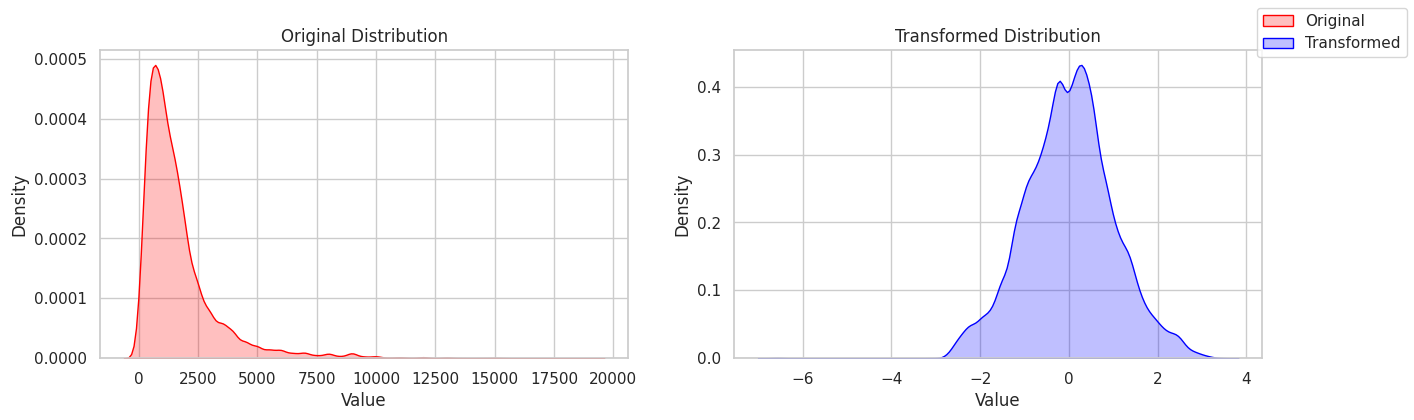

In [136]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# Plot the original distribution on the first subplot
sns.kdeplot(y_train, fill=True, color='red', label='Original', ax=ax1)
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')
ax1.set_title('Original Distribution')

# Plot the transformed distribution on the second subplot
sns.kdeplot(y_train_transformed, shade=True, color='blue', label='Transformed', ax=ax2)
ax2.set_xlabel('Value')
ax2.set_ylabel('Density')
ax2.set_title('Transformed Distribution')

# Display legend for both subplots
fig.legend()

# Show the plot
plt.show()

In [64]:
# To again transform the data back to teh 
# y_train_inverse = pt.inverse_transform(y_train_transformed.reshape(-1, 1))

# Model training

In [43]:
# Instantiating the model
lr_model = LinearRegression()

In [ ]:
# Training the model
lr_model.fit(X_train,y_train_transformed)

In [28]:
# Let's get predicted values 
trsnformed_predictions = lr_model.predict(X_test)
original_predictions = pt.inverse_transform(predictions.reshape(-1, 1))

In [45]:
def calculate_regression_metrics(model, X, y_actual, cv=5):
    """
    Calculate various regression model performance metrics.

    Parameters:
    - model: Regression model object with 'fit' and 'predict' methods.
    - X: Features (independent variables).
    - y_actual: Target variable (dependent variable).
    - cv: Number of cross-validation folds.

    Returns:
    - metrics_dict: Dictionary containing performance metrics.
    """

    # Make predictions using cross-validation
    y_pred_transformed = cross_val_predict(model, X, y_actual, cv=cv)
    y_pred_inverse_transformed = pt.inverse_transform(y_pred_transformed.reshape(-1, 1))

    # Calculate metrics
    mse = mean_squared_error(y_actual, y_pred_inverse_transformed)
    mae = mean_absolute_error(y_actual, y_pred_inverse_transformed)
    r2 = r2_score(y_actual, y_pred_inverse_transformed)

    metrics_dict = {
        'Mean Squared Error (MSE)': mse,
        'Mean Absolute Error (MAE)': mae,
        'R-squared (R2)': r2
    }

    return metrics_dict

# Let's get preformance metrics values
calculate_regression_metrics(lr_model,X_test,y_test)

In [46]:
# Let's get predicted values 
trsnformed_predictions = lr_model.predict(X_test)
original_predictions = pt.inverse_transform(trsnformed_predictions.reshape(-1, 1))
original_predictions[:5]

{'Mean Squared Error (MSE)': 6.655284398366898e+96,
 'Mean Absolute Error (MAE)': 1.8681838028584666e+47,
 'R-squared (R2)': -2.2807342222567413e+90}

array([[1659.86666241],
       [ 861.73930466],
       [ 605.31202012],
       [1197.62038084],
       [4193.92964894]])

In [141]:
def scorer(model_name, model):
    """
    This function will take a model name as input and inject that model into the training pipeline to process 
    and train the model by using the training data. After that this function will use K fold cross validation technique
    to calculate the average (r2 score) and the mean absolute error
    """
    
    output = []
    output.append(model_name)
    
    # Stacking column transformers to create a Training pipeline
    Training_pipeline = Pipeline(steps = [('Scaling',scaling_transformer),('regressor', model)])
    
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(Training_pipeline, X_train, y_train, cv=kfold, scoring='r2')
    output.append(scores.mean())
    
    # Training the model and getting predictions
    Training_pipeline.fit(X_train,y_train)
    y_pred_trans = Training_pipeline.predict(X_test)
    y_pred_inverse_transformed = pt.inverse_transform(y_pred_trans.reshape(-1, 1))
    output.append(mean_absolute_error(y_test,y_pred_inverse_transformed))
    
    return output

In [142]:
model_dict = {
    'linear_reg':LinearRegression(),
    # 'svr':SVR(),
    # 'ridge':Ridge(),
    # 'LASSO':Lasso(),
    # 'decision tree': DecisionTreeRegressor(),
    # 'random forest':RandomForestRegressor(),
    # 'extra trees': ExtraTreesRegressor(),
    # 'gradient boosting': GradientBoostingRegressor(),
    # 'adaboost': AdaBoostRegressor(),
    # 'mlp': MLPRegressor(),
    # 'xgboost':XGBRegressor()
}

In [143]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [144]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])
model_df.sort_values(['mae'])

,name,r2,mae
0,linear_reg,0.569211,2.620555e+44


# Model training

# Model evaluation